# Bike sharing prediction

In this project, we'll build multilayer neural network and use it to predict daily bike rental ridership. 


## Overall flow

1. Load the data
2. Identify and dummify categorical variables, and drop original categorical variables
3. Standardize continous variables
4. Drop unnecessary columns
5. Split the data into features and targets
6. Separate the data into training, validation, and test sets, taking into account the data type to prevent leakage
7. Train model using training data with different parameters and validate the performance using validation data
8. Apply the selected model to the test data
9. Reflect on the performance of the model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. 

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. We'll be trying to capture all this with our model.

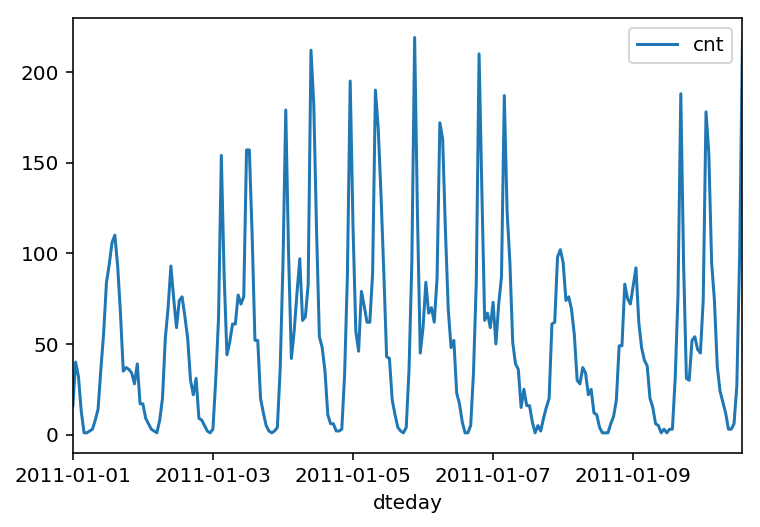

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This can be done with Pandas `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

In [6]:
data.columns

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
train_data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [10]:
print(len(train_features)/24, len(val_features)/24, len(test_features)/24)
print(train_features.shape)

643.125 60.0 21.0
(15435, 56)


## Time to build the network

Below we'll build our network. We'll implement both the forward pass and backwards pass through the network. We'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="figures/neural_network.jpg" width=300px>

The network has two layers: a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

We'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. 

Below, we have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.  

In [11]:
from helper import NeuralNetwork

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of the network implementation. This will help us be sure our network was implemented correctly before we start to train it. 

In [13]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

input_nodes = 3
hidden_nodes = 2
output_nodes = 1
learning_rate = 0.5

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here we'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but we're not overfitting to the data. If we train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

We'll also be using a method known as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, we grab a random sample of the data instead of using the whole data set. We use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. We'll learn more about SGD later.

### Choose the number of iterations

This is the number of batches of samples from the training data we'll use to train the network. The more iterations we use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if we use too many iterations.  We want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate

This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if we effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes

In a model where all the weights are optimized, the more hidden nodes we have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes we have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Let us try a few different numbers and see how it affects the performance. We can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units we choose.  We'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

## Parameter selection approach

The model was trained for 5000 iterations with randomly selected 128 training samples with number of hidden nodes in the range of 5 to 25 in steps of 5 and learning rates in the range of 0.2 to 0.75 in steps of 0.05. 

In [56]:
import sys
from itertools import product

####################
### Set the hyperparameters in your myanswers.py file ###
####################

from helper import iterations, learning_rate, hidden_nodes, output_nodes

hidden_nodes_coll = [5, 10, 15, 20, 25]
learning_rate_coll = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
iterations = 5000

loss_coll = []
for hidden_nodes, learning_rate in product(hidden_nodes_coll, learning_rate_coll):
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[], 'nH':[], 'lr':[]}
    losses['lr'] = learning_rate
    losses['nH'] = hidden_nodes
    for ii in range(iterations):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

        network.train(X, y)

        # Printing out the training progress
        train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                         + "% ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5])
        sys.stdout.flush()

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
    loss_coll.append(losses)
    print(' ')
    print('LR: ', learning_rate, 'nH: ', hidden_nodes, 'train loss: ', losses['train'][-1], 'val loss: ', losses['validation'][-1])

In [44]:
loss_overall = {'train_5':[], 'train_10':[], 'train_15':[], 'train_20':[], 'train_25':[],
                'val_5':[], 'val_10':[], 'val_15':[], 'val_20':[], 'val_25':[]}
for losses in loss_coll:
    if losses['nH'] == 5:
        loss_overall['train_5'].append(losses['train'][-1])  
        loss_overall['val_5'].append(losses['validation'][-1])
    elif losses['nH'] == 10:
        loss_overall['train_10'].append(losses['train'][-1])  
        loss_overall['val_10'].append(losses['validation'][-1])
    elif losses['nH'] == 15:
        loss_overall['train_15'].append(losses['train'][-1])  
        loss_overall['val_15'].append(losses['validation'][-1])
    elif losses['nH'] == 20:
        loss_overall['train_20'].append(losses['train'][-1])  
        loss_overall['val_20'].append(losses['validation'][-1])
    elif losses['nH'] == 25:
        loss_overall['train_25'].append(losses['train'][-1])  
        loss_overall['val_25'].append(losses['validation'][-1])

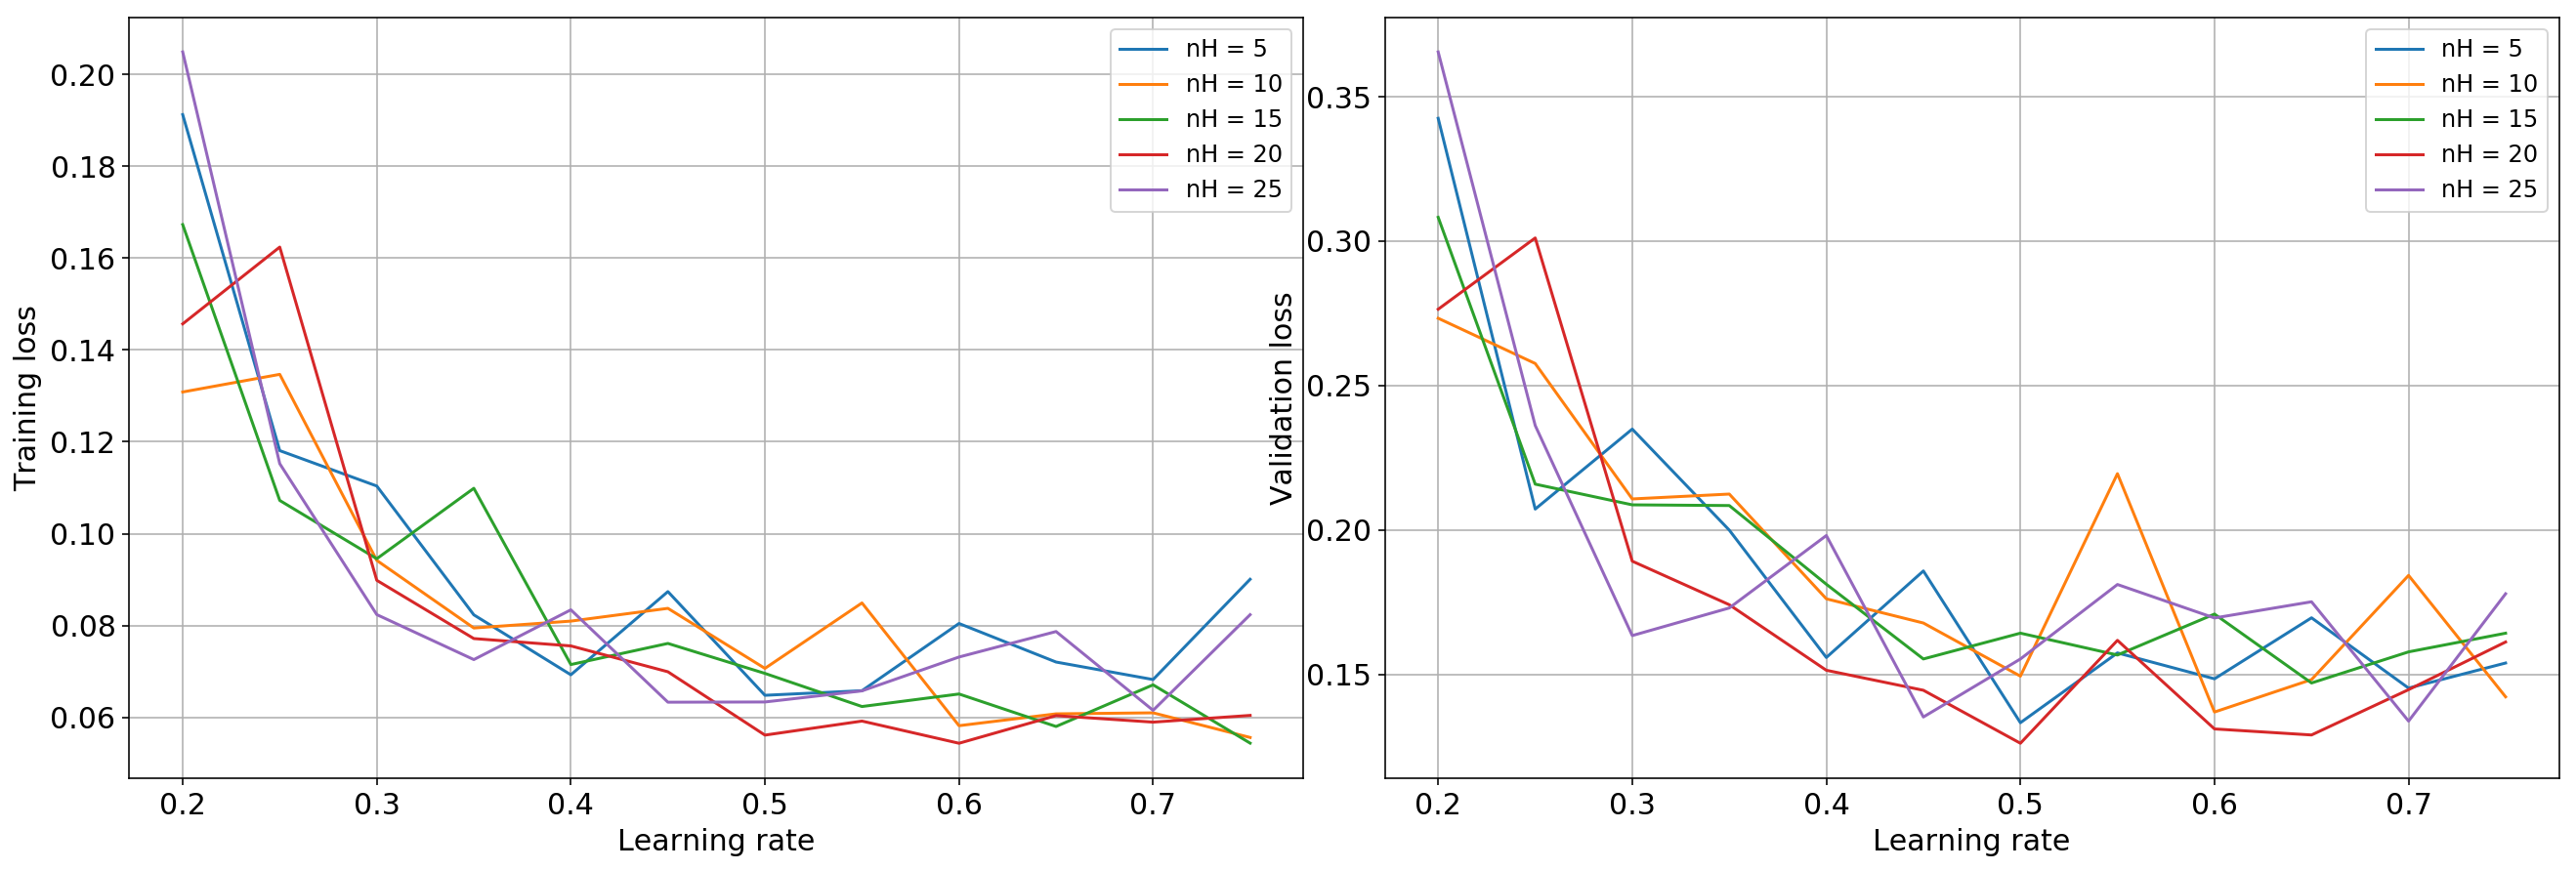

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

learning_rate_coll = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
fsize = 15

ax1.plot(learning_rate_coll, loss_overall['train_5'], label='nH = 5')
ax1.plot(learning_rate_coll, loss_overall['train_10'], label='nH = 10')
ax1.plot(learning_rate_coll, loss_overall['train_15'], label='nH = 15')
ax1.plot(learning_rate_coll, loss_overall['train_20'], label='nH = 20')
ax1.plot(learning_rate_coll, loss_overall['train_25'], label='nH = 25')
ax1.set_xlabel('Learning rate', fontsize = fsize)
ax1.set_ylabel('Training loss', fontsize = fsize)
ax1.legend()
ax1.tick_params(labelsize = fsize)
ax1.grid()
ax1.legend(fontsize = 12)

ax2.plot(learning_rate_coll, loss_overall['val_5'], label='nH = 5')
ax2.plot(learning_rate_coll, loss_overall['val_10'], label='nH = 10')
ax2.plot(learning_rate_coll, loss_overall['val_15'], label='nH = 15')
ax2.plot(learning_rate_coll, loss_overall['val_20'], label='nH = 20')
ax2.plot(learning_rate_coll, loss_overall['val_25'], label='nH = 25')
ax2.set_xlabel('Learning rate', fontsize = fsize)
ax2.set_ylabel('Validation loss', fontsize = fsize)
ax2.legend()
ax2.tick_params(labelsize = fsize)
ax2.grid()
ax2.legend(fontsize = 12)

plt.savefig('Impact_of_LR_and_nH.jpg', bbox_inches='tight', orientation='landscape', dpi=300)

## Final parameter set

The desired specification of training loss less than 0.09 and validation loss less than 0.18 could be obtained with hidden units as few as 5 units at a learning rate at 0.4. Better performance could be obtained with 20 hidden units at learning rate of 0.5. Our final model was trained with full training set for 5000 iterations with 20 hidden units at a learning rate of 0.5.

In [64]:
import sys

####################
### Set the hyperparameters in your myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    batch = np.random.choice(train_features.index, size=len(train_features))
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)  

Progress: 100.0% ... Training loss: 0.056 ... Validation loss: 0.149

Text(0.5,1,'n_hidden: 20  lr: 0.5')

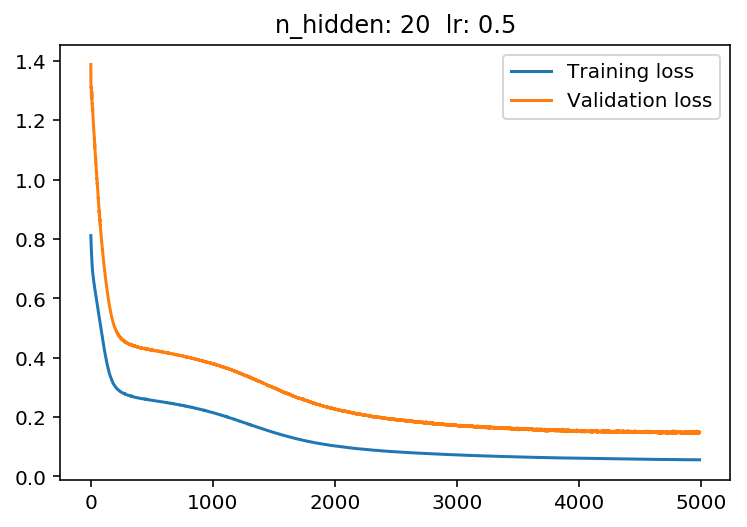

In [68]:
plt.figure()
plt.plot(losses['train'][10:], label='Training loss')
plt.plot(losses['validation'][10:], label='Validation loss')
plt.legend()
_ = plt.ylim()
plt.title('n_hidden: ' + str(hidden_nodes) + '  lr: ' + str(learning_rate))

## Check out your predictions

Here, we use the test data to view how well our network is modeling the data. If something is completely wrong here, we need to make sure each step in our network is implemented correctly.

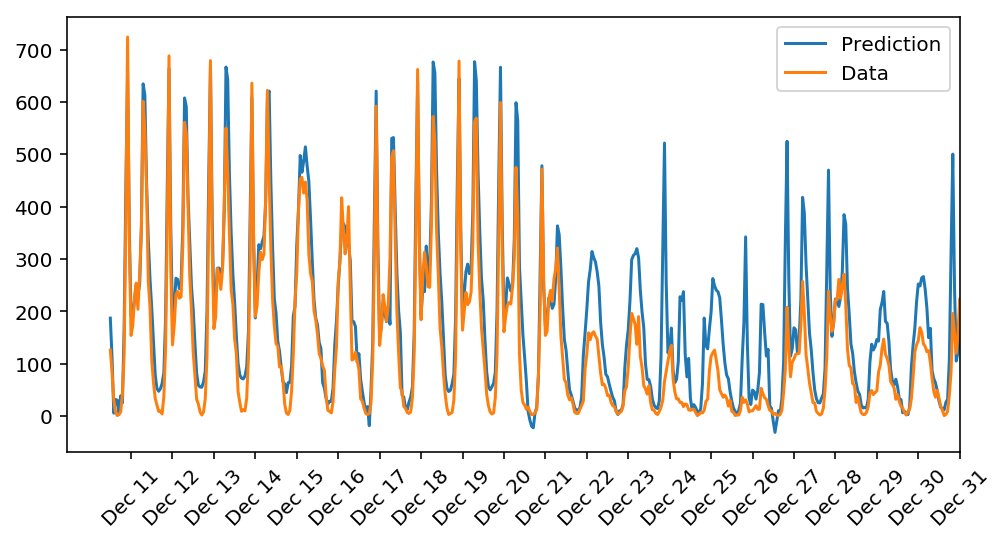

In [69]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

* The model does an excellent job on the unseen test dataset on regular days due to large number of regular days in the training set. 
* However, the model is not able to generalize well during the holidays such as the week of Christmas due to fewer number of holiday samples.